In [5]:
# import sys/os
import sys, os

# get current directory
path = os.getcwd()

# get parent directory
parent_directory = os.path.sep.join(path.split(os.path.sep)[:-2])

# add utils folder to current working path
sys.path.append(parent_directory+"/subfunctions/utils")

# add integration folder to current working path
sys.path.append(parent_directory+"/subfunctions/integration")

# Overview

In the following demo we illustrate how to compute basic quantities such as the velocity $ \mathbf{v}(\mathbf{x},t) $ and the flow map $ \mathbf{F}_{t_0}^t(\mathbf{x}_0) $ on a general two dimensional steady/unsteady velocity dataset. Particle trajectories $ \mathbf{x}(t;t_0,\mathbf{x_0}) $ launched from the initial position $ \mathbf{x}_0 $ at time $ t_0 $ satisfy the following ODE:

\begin{equation}
\mathbf{\dot{x}}(t) = \mathbf{v}(\mathbf{x}, t)
\end{equation}

The time-dependent velocity field $ \mathbf{v}(\mathbf{x}, t) $ is given on a gridded domain ($ X, Y $). In this demo we choose the AVISO dataset, which is a commonly used oceanographic dataset. This notebook is structured as follows:

1. Import data from the file 'AVISO.mat' stored in the folder 'data/AVISO'.
<br />

2. Define computational parameters (such as the number of cores) and variables.
 <br />
 
3. Interpolate velocity from the (discrete) gridded data.
 <br />
 
4. Compute trajectory $ \mathbf{x}(t;t_0,\mathbf{x}_0) $ over the time-interval [$t_0, t$] with initial condition $ \mathbf{x}_0 $. Flow map is defined as:

\begin{equation}
\mathbf{F}_{t_0}^t(\mathbf{x}_0): \mathbf{x}_0 \rightarrow \mathbf{x}(t;t_0,\mathbf{x}_0)
\end{equation}
 <br />

# Import data

In [6]:
# import scipy
import scipy.io as sio

#Import velocity data from file in data-folder
mat_file = sio.loadmat('../../data/Aviso/AVISO.mat')

U = mat_file['u'] # x-component of the velocity-field, shape (Ny, Nx, Nt)
V = mat_file['v'] # y-component of the velocity field, shape (Ny, Nx, Nt)

# Note: For steady velocity field the time dimension is dropped and the velocity arrays U and V have dimension (Ny, Nx)

x = mat_file['x'] # x-domain, shape (1,Nx)
y = mat_file['y'] # y-domain, shape: (1,Ny)
time_data = mat_file['t'] # time, shape: (1,Nt)

# Computational parameters and data

Here we define the computational parameters and the data.

In [7]:
# import numpy
import numpy as np

# Number of cores for parallel computing
Ncores = 10

# Time resolution of data
dt_data = time_data[0, 1]-time_data[0,0]

# Periodic boundary conditions
periodic_x = False
periodic_y = False
periodic_t = False
periodic = [periodic_x, periodic_y, periodic_t]

# Unsteady velocity field
bool_unsteady = True

# Defined domain
defined_domain = np.isfinite(U[:,:,0]).astype(int)

## Compute meshgrid of dataset
X, Y = np.meshgrid(x, y)

## Resolution of meshgrid
dx_data = X[0,1]-X[0,0]
dy_data = Y[1,0]-Y[0,0]

delta = [dx_data, dy_data]

# Interpolate velocity

In order to evaluate the velocity field at arbitrary locations and times, we interpolate the discrete velocity data. The interpolation with respect to time is always linear. The interpolation with respect to space can be chosen to be "cubic" or "linear". Default value is "cubic".

In [8]:
# Import interpolation function for unsteady flow field
from ipynb.fs.defs.Interpolant import interpolant_unsteady

# Set nan values to zero (in case there are any) so that we can apply interpolant. 
# Interpolant does not work if the array contains nan values. 
U[np.isnan(U)] = 0
V[np.isnan(V)] = 0

# Interpolate velocity data using cubic spatial interpolation
Interpolant = interpolant_unsteady(X, Y, U, V, method = "cubic") # method = "linear" leads to linear interpolation

# Interpolant is a list containing two interpolation objects:

Interpolant_u = Interpolant[0] # Interpolant for U-array
Interpolant_v = Interpolant[1] # Interpolant for V-array

# IMPORTANT: We assume that the velocity field is on a gridded and evenly spaced domain. 
# We also assume for unsteady velocity fields, that the time is evenly spaced.

# Compute trajectory

In [9]:
# Import function to compute flow map/particle trajectories
from ipynb.fs.defs.integration_dFdt import integration_dFdt

# Initial time (in days)
t0 = 0

# Final time (in days)
tN = 10

# Time step-size (in days)
dt = .01

# NOTE: For computing the backward trajectories set: tN < t0 and dt < 0.

time = np.arange(t0, tN+dt, dt) # len(time) = N

x0 = np.array([-5, -30]).reshape(2,-1)

Fmap, DFDt = integration_dFdt(time, x0, X, Y, Interpolant_u, Interpolant_v, periodic, bool_unsteady, time_data, verbose=True)

Percentage completed:  0.0
Percentage completed:  10.0
Percentage completed:  20.0
Percentage completed:  30.0
Percentage completed:  40.0
Percentage completed:  50.0
Percentage completed:  60.0
Percentage completed:  70.0
Percentage completed:  80.0
Percentage completed:  90.0


## Plot trajectory $ \mathbf{x}(t;t_0,\mathbf{x}_0) $

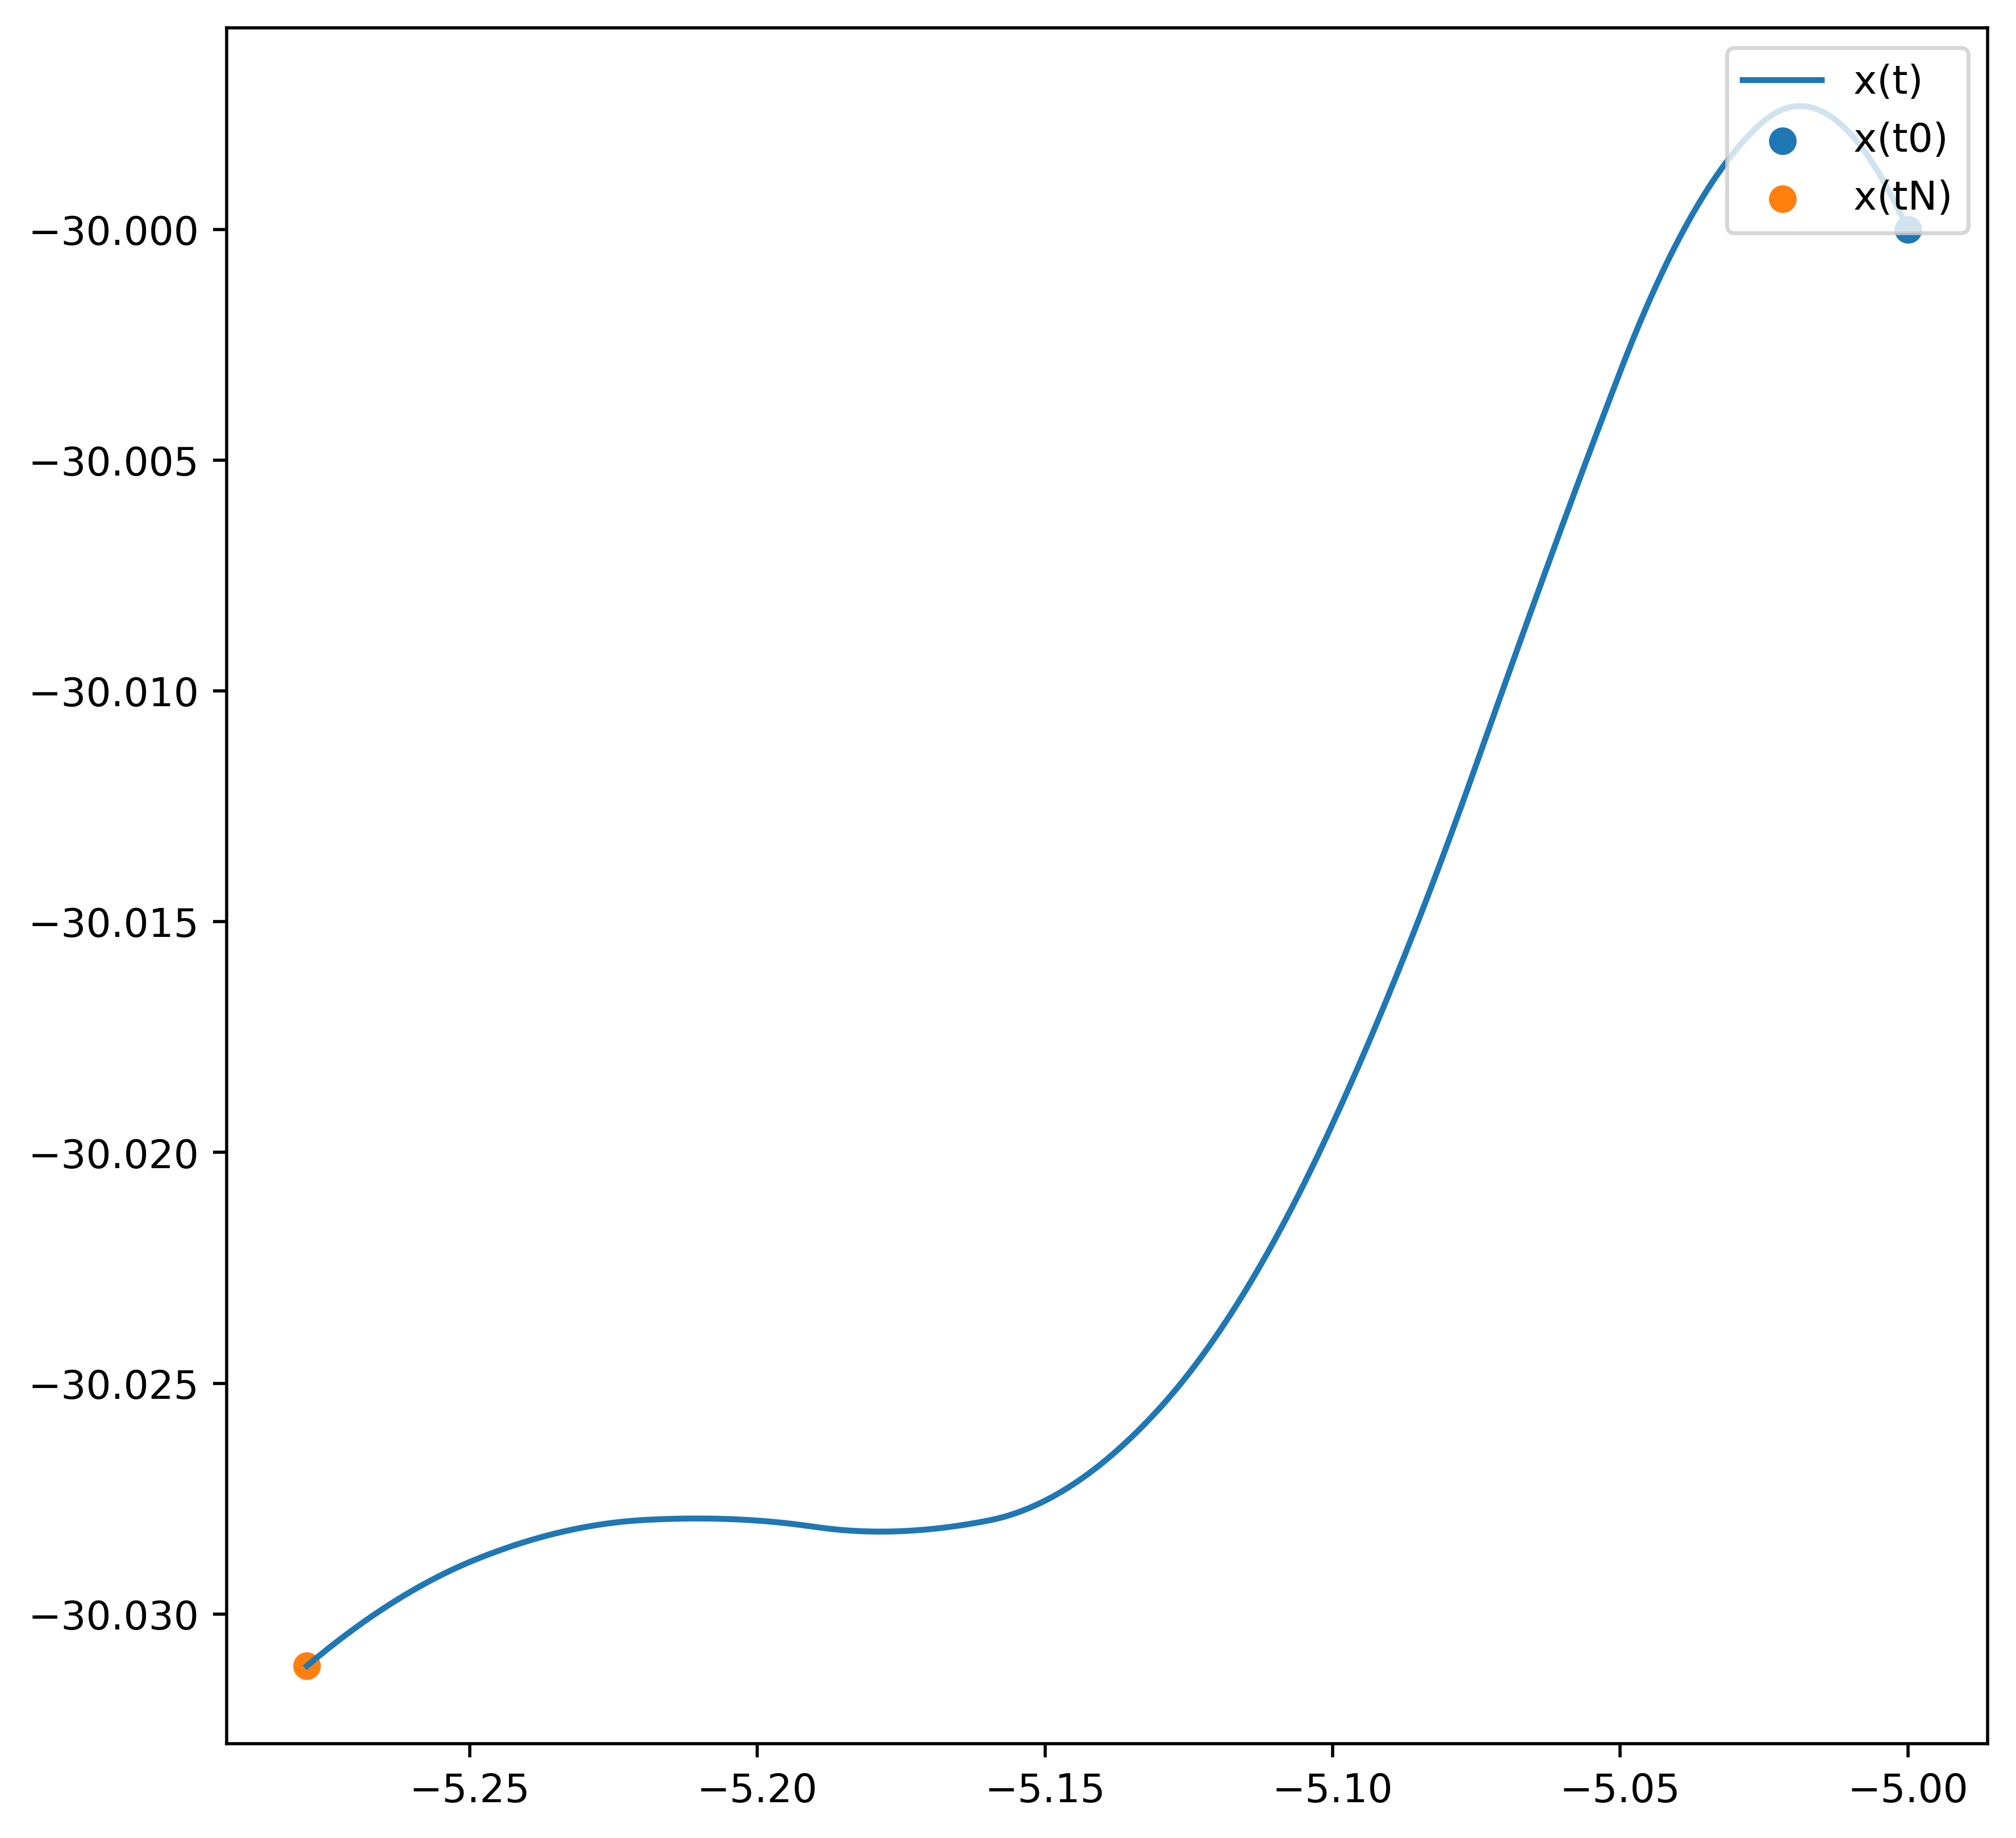

In [11]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (8, 8), dpi = 500)
ax = plt.axes()
ax.scatter(Fmap[0,0,0], Fmap[0,1,0], label = "x(t0)")
ax.scatter(Fmap[-1,0,0], Fmap[-1,1,0], label = "x(tN)")
ax.plot(Fmap[:,0,0], Fmap[:,1,0], label = "x(t)")
ax.legend(loc = "upper right")
plt.show()

# References

[1] Chapter 2.2 Lagrangian Description of Fluid particles in "Transport Barriers and Coherent Structures in Flow Data" by Prof. George Haller.

[2] [YouTube tutorial](https://www.youtube.com/watch?v=_mPiU59PzgE&list=PLJHY7IecnoJwGg7xPr2Qiw1-fmnIfPnLu&index=4)